In [127]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [128]:
# Define Constants and Variables, must be edited by user
sp_folder = r"C:\Data\Apig\A240209"  #must contain SP files and info file. 
sp_folder = os.path.join(sp_folder, "")

In [129]:
# Cell 3: Create Directories
save_directory_ascii15 = os.path.join(sp_folder, "-ascii_eq15")
if not os.path.exists(save_directory_ascii15):
    os.makedirs(save_directory_ascii15)

save_directory_ascii17 = os.path.join(sp_folder, "-ascii_eq17")
if not os.path.exists(save_directory_ascii17):
    os.makedirs(save_directory_ascii17)

In [130]:
# Construct File Paths and Read Data
file_name = "info.xlsx"
file_path = os.path.join(sp_folder, file_name)

# Check if the file exists before reading
if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"Error: File '{file_name}' not found.")
    # Add appropriate error handling or exit the script

# Convert the DataFrame to a dictionary
data_dict = df.to_dict(orient='records')

# Display the resulting dictionary
print(data_dict)
print(df)


[{'Sample': 1, 'Station': 'Kontroll_1', 'Date': Timestamp('2024-02-09 00:00:00'), 'V': 50, 'F': 15, 'C': 1, 'File_1': 1, 'File_2': 2, 'File_3': 3, 'File_4': 4, 'File_5': 5, 'File_6': 6, 'File_7': 7, 'File_8': 8, 'File_9': 9, 'File_10': 10, 'File_11': 11, 'File_12': 12, 'File': 'A240209', 'Comments': 'Skeletonema testfilter'}, {'Sample': 2, 'Station': 'Kontroll_2', 'Date': Timestamp('2024-02-09 00:00:00'), 'V': 50, 'F': 15, 'C': 1, 'File_1': 1, 'File_2': 2, 'File_3': 3, 'File_4': 4, 'File_5': 5, 'File_6': 6, 'File_7': 13, 'File_8': 14, 'File_9': 15, 'File_10': 16, 'File_11': 17, 'File_12': 18, 'File': 'A240209', 'Comments': 'Skeletonema testfilter'}]
   Sample     Station       Date   V   F  C  File_1  File_2  File_3  File_4  \
0       1  Kontroll_1 2024-02-09  50  15  1       1       2       3       4   
1       2  Kontroll_2 2024-02-09  50  15  1       1       2       3       4   

   File_5  File_6  File_7  File_8  File_9  File_10  File_11  File_12     File  \
0       5       6      

In [131]:
# define function apig_read

def apig_read(filename):
    with open(filename, 'r') as file:
        # Read the entire file data
        uv_data = file.read()

        # Split the data into lines
        lines = uv_data.strip().split('\n')

        # Extract wavelength and absorbance values from line 86 to the end
        data_lines = lines[86:]

        # Parse the data lines using NumPy
        data_pairs = np.array([list(map(float, line.split('\t'))) for line in data_lines])
    a=data_pairs

    return a

In [132]:
#define function apig calculate

def apig_calculate15(f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, VO, FO, CO):
    # Convert input strings to numpy arrays
    file1 = np.array(f1, dtype=float) #Black open measurement
    file2 = np.array(f2, dtype=float) #White 98% reflectance
    file3 = np.array(f3, dtype=float) #Blank,reflectance
    file4 = np.array(f4, dtype=float) #Blank transmittance
    file5 = np.array(f5, dtype=float) #Blank bleached reflectance
    file6 = np.array(f6, dtype=float) #Blank bleached transmittance
    file7 = np.array(f7, dtype=float) #Sample transmittance
    file8 = np.array(f8, dtype=float) #Sample transmittance turned
    file9 = np.array(f9, dtype=float) #Sample Reflectance
    file10 = np.array(f10, dtype=float) #Bleached sample transmittance
    file11 = np.array(f11, dtype=float) #Bleached sample transmittance turned
    file12 = np.array(f12, dtype=float) #Bleached sample reflectance

    print(file1) #a qc check vs SP files

    w = file1[:, 0]  # collects the wavelengths [:,0]=first column of arrayin file 1
    file7 = file7[:, 1] / 100 # only collects absorbance from column 2
    file4 = file4[:, 1] / 100
    file9 = file9[:, 1] / 100
    file3 = file3[:, 1] / 100
    file8 = file8[:, 1] / 100
    file2 = file2[:, 1] / 100

    # calculates parameters for unbleached filters
    unbl_rho_T = file7 / file4
    unbl_rho_R = file9 / file3
    unbl_Tau = (1 - file8) / (1 - file7)
    unbl_Rf = file3
    unbl_as = (1 - unbl_rho_T + unbl_Rf * (unbl_rho_T - unbl_rho_R)) / (1 + unbl_rho_T * unbl_Rf * unbl_Tau)
    unbl_As = np.log10(1 / (1 - unbl_as))

    # calculates parameters for bleached filters
    file10 = file10[:, 1] / 100
    file6 = file6[:, 1] / 100
    file5 = file5[:, 1] / 100
    file12 = file12[:, 1] / 100
    file11 = file11[:, 1] / 100

    bl_rho_T = file10 / file6
    bl_rho_R = file12 / file5
    bl_Tau = (1 - file11) / (1 - file10)
    bl_Rf = file5
    bl_as = (1 - bl_rho_T + bl_Rf * (bl_rho_T - bl_rho_R)) / (1 + bl_rho_T * bl_Rf * bl_Tau)
    bl_As = np.log10(1 / (1 - bl_as))

    # Calculates Aspig for as difference between unbleached and bleached
    Aspig = unbl_As - bl_As

    # Estimates the absorbance in suspension (Od_sus) from different equations from earlier work on filter->suspension correlations (T&F eq. 15 (Mitchell and
    # Kiefer (1984,1988) and eq. 16 (Cleveland and Weidemann (1993)) and eq. 17 (Tassan % Ferrari 1995, 2002)

    total_As_15 = 0.392 * unbl_As + 0.665 * (unbl_As ** 2)
    total_As_16 = 0.378 * unbl_As + 0.523 * (unbl_As ** 2)
    total_As_17 = 0.423 * unbl_As + 0.479 * (unbl_As ** 2) # ODsus in Tassan Ferrari 2002

    Asuspig_eq15 = 0.392 * Aspig + 0.665 * (Aspig ** 2)
    Asuspig_eq16 = 0.378 * Aspig + 0.523 * (Aspig ** 2)
    Asuspig_eq17 = 0.423 * Aspig + 0.479 * (Aspig ** 2)

    Asusbp_eq15 = 0.392 * bl_As + 0.665 * (bl_As ** 2)
    Asusbp_eq16 = 0.378 * bl_As + 0.523 * (bl_As ** 2)
    Asusbp_eq17 = 0.423 * bl_As + 0.479 * (bl_As ** 2)

    C = CO # Concentration (info not available yet (20.10.2008)) 
    V = VO # Volume of filtered sample (in ml)
    F = FO # Filter material diameter (in mm) NB! This should be Filter clearance area when filtering, not diameter of whole filter

    X = V / (np.pi * (0.5 * F) ** 2)

    total_eq15 = 2.3 * total_As_15 / (X * C)
    total_eq16 = 2.3 * total_As_16 / (X * C)
    total_eq17 = 2.3 * total_As_17 / (X * C)

    #nytt
    total_eq15=total_eq15-total_eq15[w == 750];
    total_eq16=total_eq16-total_eq16[w == 750];
    total_eq17=total_eq17-total_eq17[w == 750];
    #nytt*
    
    # -OD at 750 because pigments should not absorb there
    alpha_pig_eq15 = 2.3 * Asuspig_eq15 / (X * C) # Calculates chl a specific absorption coefficient (unit: 1/m)
    alpha_pig_eq16 = 2.3 * Asuspig_eq16 / (X * C)
    alpha_pig_eq17 = 2.3 * Asuspig_eq17 / (X * C)
    alpha_pig_eq15 = alpha_pig_eq15 - alpha_pig_eq15[w == 750]
    alpha_pig_eq16 = alpha_pig_eq16 - alpha_pig_eq16[w == 750]
    alpha_pig_eq17 = alpha_pig_eq17 - alpha_pig_eq17[w == 750]
    
    # some sediments can absorb in 750 so should not normalize (iron oxides etc
    alpha_bp_eq15 = 2.3 * Asusbp_eq15 / (X * C)
    alpha_bp_eq16 = 2.3 * Asusbp_eq16 / (X * C)
    alpha_bp_eq17 = 2.3 * Asusbp_eq17 / (X * C)

    #nytt*
    alpha_bp_eq15=alpha_bp_eq15-alpha_bp_eq15[w == 750];
    alpha_bp_eq16=alpha_bp_eq16-alpha_bp_eq16[w == 750];
    alpha_bp_eq17=alpha_bp_eq17-alpha_bp_eq17[w == 750];
    #nytt*

    a15_1 = total_eq15
    a15_2 = alpha_bp_eq15
    a15_3 = alpha_pig_eq15

    a17_1 = total_eq17
    a17_2 = alpha_bp_eq17
    a17_3 = alpha_pig_eq17

    return a15_1, a15_2, a15_3,a17_1, a17_2, a17_3


Kontroll_1_1_2024-02-09
[[900.      3.348]
 [899.      3.368]
 [898.      3.355]
 ...
 [352.      2.222]
 [351.      2.24 ]
 [350.      2.192]]
Kontroll_2_2_2024-02-09
[[900.      3.348]
 [899.      3.368]
 [898.      3.355]
 ...
 [352.      2.222]
 [351.      2.24 ]
 [350.      2.192]]


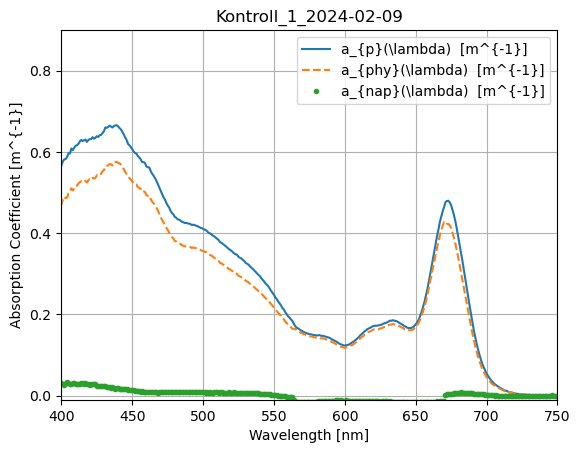

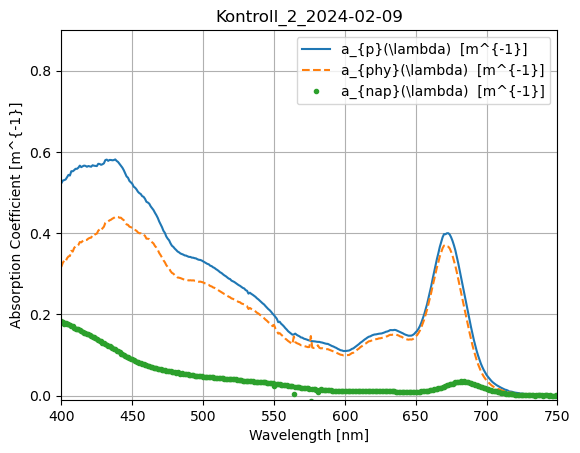

In [133]:
# Calculate data
#    # Store the appended and formatted list 
calc443table17 = []

for index, row in df.iterrows():
    sample_number = row['Sample']
    Vo=row['V']
    Fo=row['F']
    Co=row['C']
    station=row['Station']
    # Format the date as a string without the time component
    date = row['Date'].strftime('%Y-%m-%d')


    f1 = apig_read(os.path.join(sp_folder, f"{int(row['File_1']):02d}.SP")) 
    f2 = apig_read(os.path.join(sp_folder, f"{int(row['File_2']):02d}.SP"))
    f3 = apig_read(os.path.join(sp_folder, f"{int(row['File_3']):02d}.SP"))
    f4 = apig_read(os.path.join(sp_folder, f"{int(row['File_4']):02d}.SP"))
    f5 = apig_read(os.path.join(sp_folder, f"{int(row['File_5']):02d}.SP"))
    f6 = apig_read(os.path.join(sp_folder, f"{int(row['File_6']):02d}.SP"))
    f7 = apig_read(os.path.join(sp_folder, f"{int(row['File_7']):02d}.SP"))
    f8 = apig_read(os.path.join(sp_folder, f"{int(row['File_8']):02d}.SP"))
    f9 = apig_read(os.path.join(sp_folder, f"{int(row['File_9']):02d}.SP"))
    f10 = apig_read(os.path.join(sp_folder, f"{int(row['File_10']):02d}.SP"))
    f11 = apig_read(os.path.join(sp_folder, f"{int(row['File_11']):02d}.SP"))
    f12 = apig_read(os.path.join(sp_folder, f"{int(row['File_12']):02d}.SP"))


    print(f"{station}_{sample_number}_{date}") #this is a header for the qc routine mentioned below.

    # Use apig_calculate to perform calculations
    # A qc routine within apig_calculate prints file 1 for all the samples. this should be the same as 01.SP for all.
    a15_1, a15_2, a15_3,a17_1, a17_2, a17_3 = apig_calculate15(f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, Vo, Fo, Co)

    # plott av labkjøringene
    #   Legg inn



    # Create array with wavelengths and calculated absorbance values
    w = f1[:, 0]
    xy15 = np.column_stack((w, a15_1, a15_2, a15_3))
    xy17 = np.column_stack((w, a17_1, a17_2, a17_3))

    # Save the array to a text file
    np.savetxt(os.path.join(save_directory_ascii15, f"{station}_{sample_number}_{date}.txt"), xy15, fmt='%.8f', delimiter=' ')
    np.savetxt(os.path.join(save_directory_ascii17, f"{station}_{sample_number}_{date}.txt"), xy17, fmt='%.8f', delimiter=' ')
    ap = {'w': w, 'aps':a15_2}

    plt.figure()
    plt.plot(w, a15_1, '-')
    plt.plot(w, a15_3, '--')
    plt.plot(w, a15_2, '.')
    plt.grid(True)
    plt.xlim([400, 750])
    plt.ylim([-0.01, 0.9]) #legg inn maks verdi her
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Absorption Coefficient [m^{-1}]')
    plt.legend(['a_{p}(\lambda)  [m^{-1}]', 'a_{phy}(\lambda)  [m^{-1}]', 'a_{nap}(\lambda)  [m^{-1}]'])
    plt.title(f"{station}_{date}")

    plt.savefig(os.path.join(save_directory_ascii15, f"{station}_{sample_number}_{date}.jpg"), format='jpg')
    
    tempall = [station, xy15[457, 0], xy15[457, 1], xy15[457, 2], xy15[457, 3]]
    calc443table17.append(tempall)
    
